__Что щас не сделано__
1. то, что нужно в консультации 2.11

__Вопросики__

1. ...


__Варианты улучшения ситуации по результатам консультации 29.10__

1. Малый патч -> большой батч

2. Аугментация тренировочных данных белым шумом. Вышибаем клин клином

3. Больше патч

4. Больше патч -> глубже сеть

5. Dropout оставляем только на линейных

6. Подобрать оптимальный learning rate

__Консультация 2.11__

1. Добавить метрику для сегментации

2. Собрать получившуюся маску, сравнить с исходной через вычитание

3. Пришло время U-Net

__Ситуация на 08.11__

Задачи из консультации выше не сделаны :(

Добавлено обучение Random Forest (для сравнения с глубоким обучением)

![pet](https://pbs.twimg.com/media/E2JrD27XoAIqi8l?format=jpg&name=4096x4096)

## Подготовка данных

Импорт необходимых библиотек

In [1]:
import numpy as np
from osgeo import gdal
from copy import deepcopy
from tqdm import tqdm
from tqdm import trange
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models

from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# from sklearn.metrics import plot_roc_curve
# from sklearn.metrics import PrecisionRecallDisplay

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.is_available()

True

Нам понадобятся для работы некоторые функции, соберем их тут, чтобы потом не мешались

Прежде всего, нам нужен класс для подготовки датасета. Он должен
1. Нарезать на патчи (заданного размера)
2. Определять класс центрального пиксела патча (на основе соответственного патча маски)
3. Вычислять координаты этого пиксела и складывать их куда-то, чтобы потом можно было восстановить изображение
4. Кстати, раз мы режем на патчи после отделения тестового и валидационного куска, надо также подавать значения порогов отделения, чтобы восстанавливать координаты?

In [2]:
def count_statistics(x, pr='yes'):
    x_min = np.min(x)
    x_max = np.max(x)
    x_mean = np.mean(x)
    x_std = np.std(x)
    if pr == 'yes':
        print(f"min={x_min:.2}  max={x_max:.2}  mean={x_mean:.2}  std={x_std:.2}")
    
    return x_min, x_max, x_mean, x_std

In [3]:
class Patcher(Dataset):
    def __init__(self, image, mask, transform, patch_size):
        super().__init__()
              
        self.image = image
        self.mask = mask
        self.transform = transform
        self.patch_size = patch_size
        self.im_h, self.im_w = image.shape[0], image.shape[1]
    
        half_patch = self.patch_size // 2
        coord_list = list()
        for central_x in tqdm(range(half_patch, self.im_w - half_patch)): 
            for central_y in range(half_patch, self.im_h - half_patch):
                if (self.image[central_y - half_patch:central_y + half_patch + 1,
                               central_x - half_patch:central_x + half_patch + 1] != 0).all():
                    coord_list.append([central_y, central_x])
        self.coords = np.array(coord_list)
        self.size = len(self.coords)

    def __getitem__(self, indx):
        central_x = self.coords[indx, 1]
        central_y = self.coords[indx, 0]
        
        half_patch = self.patch_size // 2
        patch = self.image[central_y - half_patch:central_y + half_patch + 1, 
                           central_x - half_patch:central_x + half_patch + 1]
        label = self.mask[central_y][central_x]
        return self.transform(patch), torch.tensor(label), indx # dataset.coords[indx]
    
    def __len__(self):
        return self.size

In [4]:
# функция для валидации
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    mcc = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train, coords = batch
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train) # get predictions
#             loss = criterion(y_pred, y_train) # compute loss
            loss = criterion(y_pred.squeeze(), y_train.to(torch.float32)) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
            y_pred = y_pred.squeeze().cpu()
            y_pred = torch.where(y_pred > 0.5, 1, 0)
            mcc_batch = matthews_corrcoef(y_train.to(torch.float32).cpu(), y_pred)
            mcc.append(mcc_batch)
    return cumloss / len(val_loader), loss_history, np.mean(mcc) # mean loss and history

In [34]:
# функция для валидации на тесте 
# прикрутить координаты
def final_validate(model, 
                  criterion,
                  test_loader):
    model.eval()
    cumloss = 0
    labels = []
    outputs = []
    coords = []
    with torch.no_grad():
        for batch in test_loader:
            patch, label, coord = batch
            patch, label = patch.to(device), label.to(device)
            y_pred = model(patch) # get predictions
            loss = criterion(y_pred.squeeze(), label.to(torch.float32)) # compute loss
            cumloss += loss
            y_pred = y_pred.squeeze().cpu()
            y_pred = torch.where(y_pred > 0.5, 1, 0)
            outputs.append(y_pred.numpy())
            labels.append(label.cpu().numpy())
            coords.append(coord)
        
    cumloss = cumloss / len(test_loader)
    outputs = np.concatenate(outputs, axis=0)
    labels = np.concatenate(labels, axis=0)
    coords = np.concatenate(coords, axis=0)
    
    print(f"loss={cumloss:.2}")
    print(f"matthews_correlation_coefficient={matthews_corrcoef(labels, outputs):.2}")
    print(f"ROC_AUC={roc_auc_score(labels, outputs):.2}")
    precision, recall, thresholds = precision_recall_curve(labels, outputs)
    print(f"Pr-Rec_AUC={auc(recall, precision):.2}")
    
    return outputs, coords

In [6]:
# функция для обучения
def train(model, train_data, test_data, criterion, optimizer, num_epochs=10):
    loss_hist = []
    accuracy_lst = []
    epochs = trange(num_epochs)
    for epoch in tqdm(epochs):
        ep_loss = 0
        model.train()
        for batch in train_data:
            imgs, labels, coords = batch
            imgs, labels = imgs.to(device), labels.to(device)     
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs.squeeze(), labels.to(torch.float32))
            loss.backward()
            optimizer.step()
            ep_loss += loss.item()
        loss_hist.append(ep_loss / len(train_data))
        
        model.eval() # dropout!
        _, val_loss, mcc = validate(model, criterion, test_data)
        accuracy_lst.append(val_loss[0])
        
        print(f"Epoch={epoch}  loss={loss_hist[epoch]:.4}  val_loss={val_loss[0]:.4}  mcc={mcc:.2}")
    return accuracy_lst, loss_hist

In [7]:
# функция для обучения c scheduler
def train_sched(model, train_data, test_data, criterion, optimizer, scheduler, num_epochs=10):

    best_loss = np.inf
    
    loss_hist = []
    accuracy_lst = []
    epochs = trange(num_epochs)
    for epoch in tqdm(epochs):
        ep_loss = 0
        model.train()
        for batch in train_data:
            imgs, labels, coords = batch
            imgs, labels = imgs.to(device), labels.to(device)     
            optimizer.zero_grad()
            outputs = model(imgs)
#             loss = criterion(outputs, labels)
            loss = criterion(outputs.squeeze(), labels.to(torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step()
            ep_loss += loss.item()
        loss_hist.append(ep_loss / len(train_data))
        
        model.eval() # dropout!
        val_loss, val_loss_hist, mcc = validate(model, criterion, test_data)
        accuracy_lst.append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model)
        
        print(f"Epoch={epoch}  loss={loss_hist[epoch]:.4}  val_loss={val_loss_hist[epoch]:.4}  mcc={mcc:.2}")
        
    return accuracy_lst, loss_hist, best_model

In [8]:
def createGeotiff(out_raster, data, geo_transform, projection):
    # Create a GeoTIFF file with the given data
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(out_raster, cols, rows, 1, gdal.GDT_Int32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None

### Загрузка и предобработка

Задаем пути на изображение, для которого будет проводиться классификация, и на маску (label)

In [9]:
raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20191021_.tif"
mask_path = "D:/oni/from_lakm/tiffs_clip/forest_mask.tif"

Открытие изображений, сохранение информации о пространственной привязке для будущего выходного изображения

In [10]:
image = gdal.Open(raster_path, gdal.GA_ReadOnly)
# получаем инфо о пространственной привязке,
# потому что просто картинка на выходе нам не нужна
# xoffset, px_w, rot1, yoffset, px_h, rot2 = image.GetGeoTransform() # для пересчета координат пикселов
geo_transform = image.GetGeoTransform()
projection = image.GetProjectionRef()

mask = gdal.Open(mask_path, gdal.GA_ReadOnly)

In [7]:
print(geo_transform)
print(projection)

499997.52242239844 10.0 0.0 6951689.007115613 0.0 -10.0
PROJCS["WGS_1984_UTM_Zone_52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]


Информация о проекции очень важна для конечного изображения, но очень бессмысленна для определения координат пикселов. Кстати, а почему я решила, что результирующее изображение будет иметь те же координаты? 

In [10]:
print('image rows and cols:', image.RasterYSize, image.RasterXSize)
print('mask rows and cols:', mask.RasterYSize, mask.RasterXSize)
print('image bands:', image.RasterCount)

image rows and cols: 6146 5008
mask rows and cols: 6146 5009
image bands: 2


Наш снимок в пикселах имеет размер 6146 на 5008, а также содержит 2 канала: это две поляризации (в случае с данными с открытого спутника Sentinel-1) VV и VH. 

А у маски другой размер! На один пиксел! За что! Раз мы сохранили инфу о простанственной привязке  для снимка, придется маску чуть изменить. Визуальный анализ показывает, что у маски на одну первую колонку больше. Спрашивается, почему, если я кропала их всех вместе, но ладно

Переводим снимок в матричку

In [11]:
image_array = image.ReadAsArray()
image_array = np.stack(image_array, axis=2) # move bands to end
image = None 

mask_array = mask.ReadAsArray()
mask_array = np.delete(mask_array, 0, 1) # del first column
mask = None

print(image_array.shape)
print(mask_array.shape)

(6146, 5008, 2)
(6146, 5008)


Нужно нормализовать каналы, поскольку известно, что радиолокационные сигналы достаточно низкие (пока из космоса до Земли долетишь, пока обратно...), а сигнал в кросс-поляризации ниже, чем в согласованной (из-за смены поляризации потери идут). Кроме того, из-за спекл-шума будет достаточно много выбросов. Minmax чувствителен к выбросам очень, standard scaler меньше.

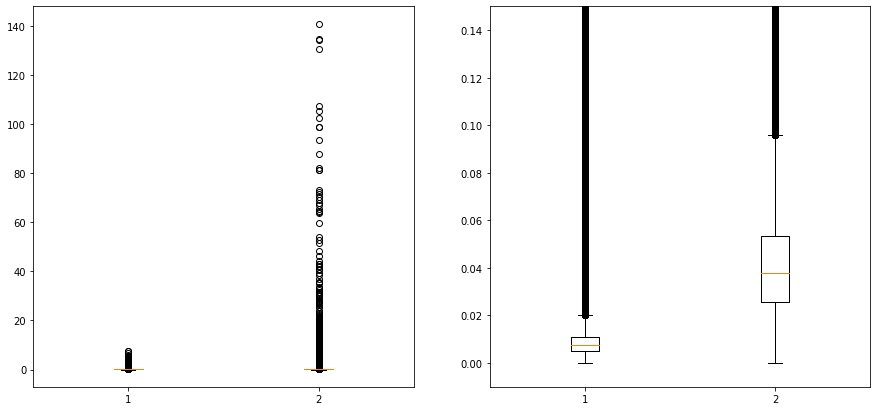

In [12]:
fig, axis = plt.subplots(1, 2, figsize=(15, 7))
axis[0].boxplot([image_array[:,:, :1].flatten(), image_array[:,:, 1:].flatten()])
axis[1].boxplot([image_array[:,:, :1].flatten(), image_array[:,:, 1:].flatten()])
axis[1].set_ylim((-0.01, 0.15))
plt.show()

На графике ящиков с усами мы видим, какое влияние оказывает спекл-шум на значения радиолокационных сигналов. Слева представлен график ящиков с усами без ограничений, справа - с приближением к межквартильному размаху. Мы можем видеть, что сигналы в кросс-поляризации действительно ниже, чем в вертикальной согласованной, а также что шумные пикселы существенно превышают в значениях значения, характерные для снимков.

Поскольку речь идет об одном снимке, мы можем нормировать его полностью.

In [12]:
print('first channel')
min_b1, max_b1, mean_b1, std_b1 = count_statistics(image_array[:,:, :1])
print()
print('second channel')
min_b2, max_b2, mean_b2, std_b2 = count_statistics(image_array[:,:, 1:])

first channel
min=0.0  max=7.7  mean=0.0086  std=0.0084

second channel
min=0.0  max=1.4e+02  mean=0.043  std=0.11


In [13]:
band_1 = (np.squeeze(image_array[:,:, :1], axis=2) - mean_b1) / std_b1
band_2 = (np.squeeze(image_array[:,:, 1:], axis=2) - mean_b2) / std_b2

In [14]:
image_norm = np.stack((band_1, band_2), axis=-1)
image_norm.shape

(6146, 5008, 2)

Посмотрим на долю лесных пикселов среди всех пикселов в маске

In [18]:
print(f'{mask_array[mask_array == 1].size / mask_array.size :.2}')

0.63


Доля 63 %, значит, наблюдается небольшой дисбаланс.

Наверное, стоит визуализировать кусочки изображений

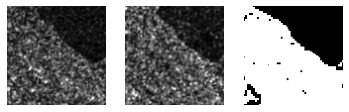

In [19]:
step = 100
figure1 = image_array[1000:1000+step, 600:600+step, :1] # ищем образцово-показательный кусочек
figure2 = image_array[1000:1000+step, 600:600+step, 1:]
figure3 = mask_array[1000:1000+step, 600:600+step]

fig, axis = plt.subplots(1, 3)
# plt.figure(figsize=(6, 6))
axis[0].imshow(figure1, cmap='Greys_r')
axis[1].imshow(figure2, cmap='Greys_r')
axis[2].imshow(figure3, cmap='Greys_r')
for a in axis:
    a.axis('off') 

Судя по всему, лес (1) белый на маске. Можно обратить внимание на то, что на снимке в выбранной поляризации не_лес темнее

Для отработки модели возьмем только часть данных для обучения и валидации

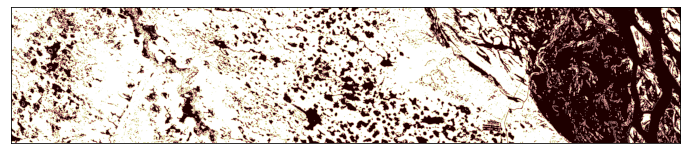

In [35]:
figure1 = mask_array[1500:2500, 100:5000]

plt.figure(figsize=(12, 16))
plt.imshow(figure1, cmap='pink')
plt.grid(False)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()  

In [13]:
# пока мы на этапе "заставить модель работать", возьмем только часть данных
# toy dataset
# bound_train = 1500
# bound_val = 2500
# bound_test = 2700

# train_image = image_array[bound_train:bound_val]
# train_labels = mask_array[bound_train:bound_val]

# val_image = image_array[bound_val:bound_test]
# val_labels = mask_array[bound_val:bound_test]

# test_image = image_array[bound_test:]
# test_labels = mask_array[bound_test:]

In [34]:
# test_image = image_array[4000:5000]
# test_labels = mask_array[4000:5000]

Настало время резать на train-test. Так как снимок содержит порядка 30 млн пикселов, оно будет иметь достаточно много патчей суммарно (в случае с попиксельной классификацией при помощи простой сверточной сети - 30 млн патчей). Поэтому можно выделить для обучения около 50 % данных, для валидации 20 %, а для теста оставшиеся 30 %. 

In [15]:
# мне хочется резать по круглым числам, поэтому
bound_val = int(image_norm.shape[0] * 0.05) * 10 # отбросить единицы при округлении 1/10 от числа
bound_test = int(image_norm.shape[0] * 0.07) * 10 
print(f"bound_val={bound_val}  bound_test={bound_test}")

train_image = image_norm[:bound_val]
train_labels = mask_array[:bound_val]

val_image = image_norm[bound_val:bound_test]
val_labels = mask_array[bound_val:bound_test]

test_image = image_norm[bound_test:]
test_labels = mask_array[bound_test:]

bound_val=3070  bound_test=4300


In [16]:
print(train_image.shape) # 6146 rows total
print(train_labels.shape)
print(val_image.shape)
print(val_labels.shape)
print(test_image.shape)
print(test_labels.shape)

(3070, 5008, 2)
(3070, 5008)
(1230, 5008, 2)
(1230, 5008)
(1846, 5008, 2)
(1846, 5008)


### Подготовка данных к загрузке в модель

Зададим трансформации. Мы хотим добавить шум в тренировочные данные, чтобы модель не учила шум, но шума среди аугментаций в пайторч нет. Придется его добавить самостоятельно

In [18]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [19]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((mean_b1, mean_b2), (std_b1, std_b2)),
    AddGaussianNoise(0., 0.2)])

valid_transform = transforms.Compose([
    transforms.ToTensor()])
#     transforms.Normalize((mean_b1, mean_b2), (std_b1, std_b2))])

Режем на патчи. Готовим датасет

In [25]:
patch_size = 15
train_dataset = Patcher(train_image, train_labels, train_transform, patch_size)
valid_dataset = Patcher(val_image, val_labels, valid_transform, patch_size)

100%|█████████████████████████████████████████████████████████████████████████████| 4994/4994 [00:30<00:00, 162.55it/s]


In [26]:
print(len(train_dataset))
print(len(valid_dataset))

15261439
6072479


In [27]:
batch_size = 1024 # все же надо тебя увеличить, иначе я вечно будут учиться

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False)

Наблюдение: батч = 512 - забивает примерно 40 % видеокарты

## Создание и обучение модели

Собираем модель

In [20]:
# class CNN_s1(nn.Module):
#     def __init__(self, patch_size: int = 5): # чтобы для разных патчей работала
#         super().__init__()
#         self.conv_stack = nn.Sequential(
#             nn.Conv2d(2, 32, 3, stride=1, padding=1), # shape: [32,patch_size,patch_size]
#             nn.MaxPool2d(2), 
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(32, 64, 3, stride=1, padding=1), # shape: [64,patch_size//2,patch_size//2] 
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(64, 128, 3, stride=1, padding=1), # shape: [128,patch_size//2,patch_siz//2e] 
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128*(patch_size//2)*(patch_size//2), 1000),
#             nn.Dropout(),
#             nn.ReLU(), 
#             nn.Linear(1000, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         scores = self.conv_stack(x)
#         return scores

In [22]:
# такая модель была на обучении 15х15
class CNN_s1(nn.Module):
    def __init__(self, patch_size: int = 5): # чтобы для разных патчей работала
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(2, 32, 3, stride=1, padding=1), # shape: [32,patch_size,patch_size]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # shape: [64,patch_size,patch_size] 
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # shape: [128,patch_size,patch_size] 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*patch_size*patch_size, 1000),
            nn.Dropout(0.25),
            nn.ReLU(), 
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

Ищем learning rate. Посмотрим для Adam и SGD.

In [30]:
start_lr = 1e-8
end_lr = 1
lr_find_epochs = 2
steps = lr_find_epochs * len(train_loader)
smoothing = 0.05

Adam

In [39]:
model_cyclic = CNN_s1(patch_size=patch_size).to(device)
criterion = nn.BCELoss().to(device)

import math 

lrs = []
losses = []
optimizer = torch.optim.Adam(model_cyclic.parameters(), lr=1e-8)
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (steps))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

for epoch in tqdm(range(lr_find_epochs)):
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train, coords = batch
        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model_cyclic(x_train)
        loss = criterion(y_pred.squeeze(), y_train.to(torch.float32))

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss = loss.detach().cpu().numpy()
        if len(losses) > 1:
            loss = smoothing * loss + (1 - smoothing) * losses[-1]
        losses.append(loss)
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lrs.append(lr_step)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [55:18<00:00, 1659.19s/it]


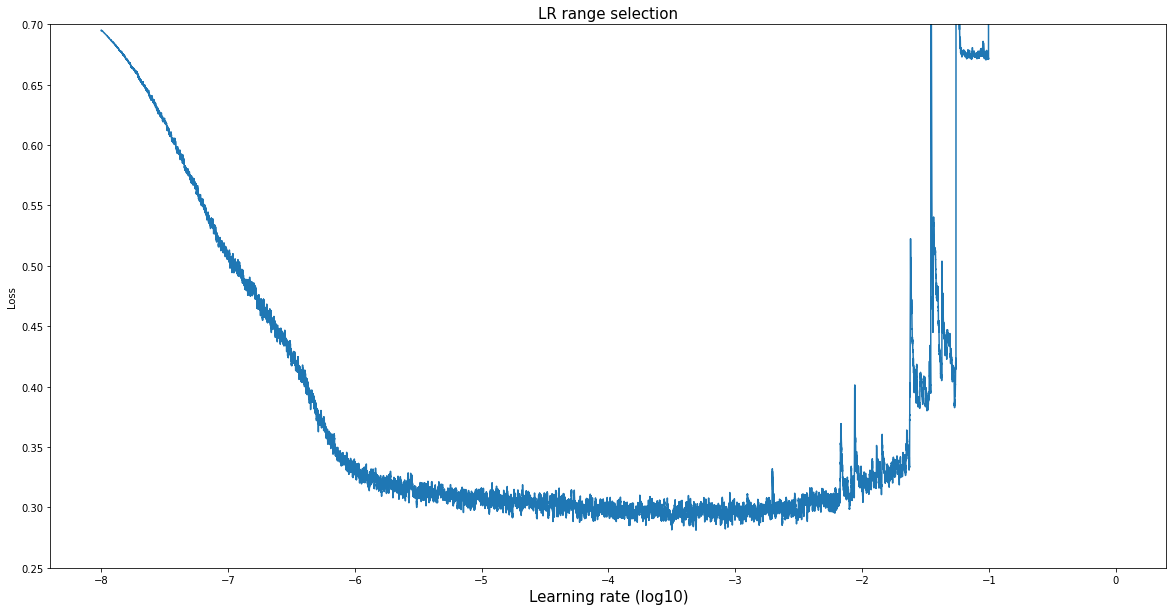

In [41]:
plt.figure(figsize=(20, 10))
plt.title("LR range selection", size=15)
plt.plot(np.log10(lrs), losses)
plt.xlabel("Learning rate (log10)",size=15)
plt.ylabel("Loss")
plt.ylim((0.25, 0.7))
plt.show()

Минимум в районе 1е-3 и начало снижения в районе 1е-8. Но циклический lr с ним не запустить, pytorch сказал, что не поддерживается такое

SGD

In [33]:
model_cyclic = CNN_s1(patch_size=patch_size).to(device)
criterion = nn.BCELoss().to(device)

import math 

lrs = []
losses = []
optimizer = torch.optim.SGD(model_cyclic.parameters(), lr=1e-8)
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (steps))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

for epoch in tqdm(range(lr_find_epochs)):
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train, coords = batch
        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model_cyclic(x_train)
        loss = criterion(y_pred.squeeze(), y_train.to(torch.float32))

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss = loss.detach().cpu().numpy()
        if len(losses) > 1:
            loss = smoothing * loss + (1 - smoothing) * losses[-1]
        losses.append(loss)
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lrs.append(lr_step)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [48:31<00:00, 1455.77s/it]


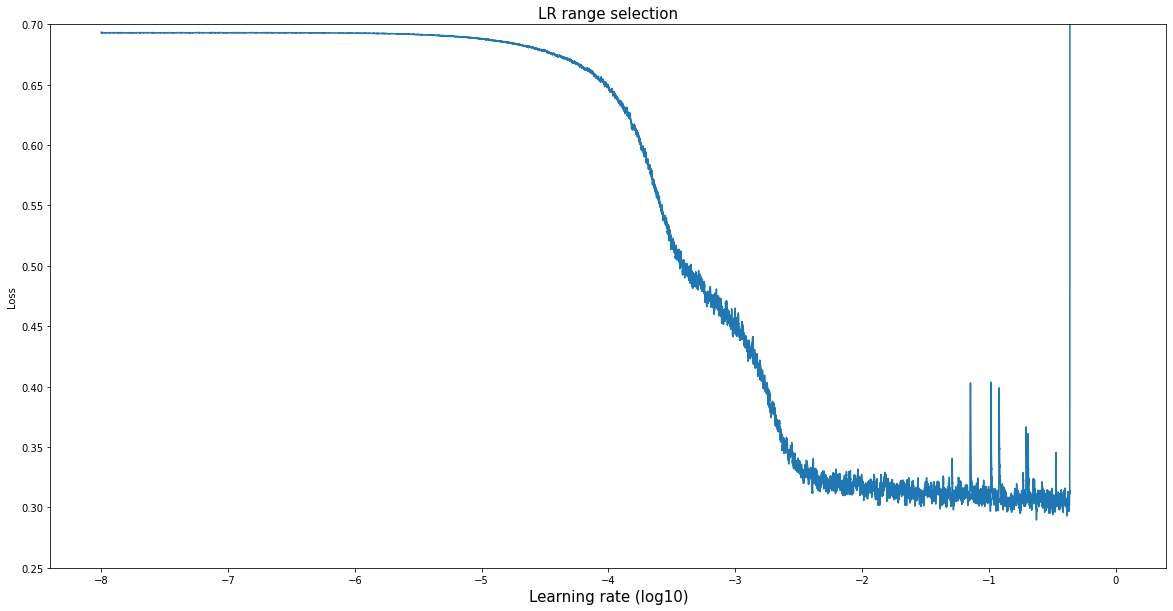

In [35]:
plt.figure(figsize=(20, 10))
plt.title("LR range selection", size=15)
plt.plot(np.log10(lrs), losses)
plt.xlabel("Learning rate (log10)",size=15)
plt.ylabel("Loss")
plt.ylim((0.25, 0.7))
plt.show()

Минимум в районе 1е-1, снижение начинается при 1е-4. Судя по лекции, на этих отметках мы видим результаты предыдущих шагов, поэтому нужно сделать сдвиг назад

In [36]:
min_lr = 1e-4 / 6
max_lr = 1e-2

In [37]:
model_SGD = CNN_s1(patch_size=patch_size).to(device)
optimizer = torch.optim.SGD(model_SGD.parameters(), lr=min_lr) # а Adam тут не работает...
criterion = nn.BCELoss()

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                        base_lr=min_lr,
                                        max_lr=max_lr,
                                        mode="triangular") 

val_loss, loss_hist, best_model = train_sched(model_SGD,
                                              train_loader,
                                              valid_loader,
                                              criterion,
                                              optimizer,
                                              scheduler,
                                              num_epochs=15)

  7%|█████▎                                                                         | 1/15 [29:19<6:50:38, 1759.88s/it]

Epoch=0  loss=0.303  val_loss=1.126  mcc=0.5



 13%|██████████▌                                                                    | 2/15 [58:40<6:21:22, 1760.16s/it]

Epoch=1  loss=0.2904  val_loss=0.5392  mcc=0.5



 20%|███████████████▍                                                             | 3/15 [1:28:02<5:52:12, 1761.04s/it]

Epoch=2  loss=0.2868  val_loss=1.196  mcc=0.49



 27%|████████████████████▌                                                        | 4/15 [1:57:25<5:23:02, 1762.03s/it]

Epoch=3  loss=0.2841  val_loss=0.5678  mcc=0.51



 33%|█████████████████████████▋                                                   | 5/15 [2:26:51<4:53:54, 1763.41s/it]

Epoch=4  loss=0.2816  val_loss=0.7717  mcc=0.51



 40%|██████████████████████████████▊                                              | 6/15 [2:56:17<4:24:37, 1764.21s/it]

Epoch=5  loss=0.2793  val_loss=0.9453  mcc=0.51



 47%|███████████████████████████████████▉                                         | 7/15 [3:25:43<3:55:18, 1764.76s/it]

Epoch=6  loss=0.2768  val_loss=0.651  mcc=0.5


 47%|███████████████████████████████████▉                                         | 7/15 [3:46:55<4:19:20, 1945.10s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), val_loss)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

15х15, циклический lr, на подвыборке

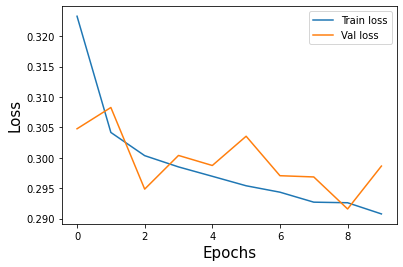

In [58]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), val_loss)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [81]:
val_outputs, val_coords = final_validate(best_model.to(device), 
                                         criterion,
                                         valid_loader)

loss=0.29
matthews_correlation_coefficient=0.75
ROC_AUC=0.86
Pr-Rec_AUC=0.93


In [80]:
torch.save(best_model, 'D:/oni/from_lakm/models/model_cnn_s1_3110_sgd.pt')

Я решила попробовать готовую модель, взяла Resnet18, но для нее патчи слишком маленькие и она просто стала зубрить тренировочный датасет. Поэтому я решила собрать Resnet попроще

In [28]:
class CustomResnet(nn.Module):
    def __init__(self, class_nums = 1):
        super(CustomResnet, self).__init__()
        self.activation = nn.ReLU()

        resnet_module = nn.Sequential(
            nn.Conv2d(2, 64, 3, stride=1, padding=1), 
            self.activation,
            BasicBlock(64, 64, 1),
            BasicBlock(64, 128, 2),
            BasicBlock(128, 128, 1),
            nn.AdaptiveAvgPool2d((1,1))
        )

        dummy_imput = torch.rand(1, 2, 15, 15)
        out = resnet_module(dummy_imput)

        self.resnet = resnet_module
        self.fc = nn.Sequential(
            nn.Linear(out.shape[1], class_nums),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet(x)
        x = nn.Flatten()(x)
        scores = self.fc(x)
        return scores

class BasicBlock(nn.Module):
    def __init__(self, conv_in, conv_out, stride_first, activation = nn.ReLU):
        super(BasicBlock, self).__init__()
        self.activation = activation()

        if stride_first == 2:
            downs_module = nn.Sequential(
            nn.Conv2d(conv_in, conv_out, 1, stride=2),
            nn.BatchNorm2d(conv_out)
            )
            self.downsample = downs_module
        else:
            self.downsample = None

        bb_module = nn.Sequential(
            nn.Conv2d(conv_in, conv_out, 3, stride=stride_first, padding=1),
            nn.BatchNorm2d(conv_out),
            self.activation,
            nn.Conv2d(conv_out, conv_out, 3, stride=1, padding=1),
            nn.BatchNorm2d(conv_out)
        )
        self.bb = bb_module

    def forward(self, x):
        x_identity = x
        out = self.bb(x)

        if self.downsample is not None: 
            x_identity = self.downsample(x) 

        out += x_identity
        out = self.activation(out)

        return out

In [29]:
model_resnet = CustomResnet().to(device)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)
criterion = nn.BCELoss()
accuracy, loss_hist = train(model_resnet, train_loader, valid_loader, criterion, optimizer, num_epochs = 10)

 10%|████████                                                                        | 1/10 [09:46<1:27:57, 586.39s/it]

Epoch=0  loss=0.3006  val_loss=0.2179  mcc=0.49



 20%|████████████████                                                                | 2/10 [19:31<1:18:07, 585.92s/it]

Epoch=1  loss=0.2903  val_loss=0.2895  mcc=0.43



 30%|████████████████████████                                                        | 3/10 [29:17<1:08:20, 585.82s/it]

Epoch=2  loss=0.281  val_loss=0.2865  mcc=0.32



 40%|████████████████████████████████▊                                                 | 4/10 [39:04<58:37, 586.23s/it]

Epoch=3  loss=0.2677  val_loss=0.3572  mcc=0.45



 50%|█████████████████████████████████████████                                         | 5/10 [48:53<48:56, 587.29s/it]

Epoch=4  loss=0.2523  val_loss=0.2919  mcc=0.47



 60%|█████████████████████████████████████████████████▏                                | 6/10 [58:39<39:06, 586.63s/it]

Epoch=5  loss=0.2385  val_loss=0.2799  mcc=0.37



 70%|████████████████████████████████████████████████████████                        | 7/10 [1:08:23<29:17, 585.99s/it]

Epoch=6  loss=0.227  val_loss=0.2583  mcc=0.47



 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:18:09<19:31, 585.79s/it]

Epoch=7  loss=0.2177  val_loss=0.2871  mcc=0.47



 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:27:53<09:45, 585.40s/it]

Epoch=8  loss=0.2098  val_loss=0.5955  mcc=0.32



100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:37:38<00:00, 585.87s/it]

Epoch=9  loss=0.2036  val_loss=0.342  mcc=0.44


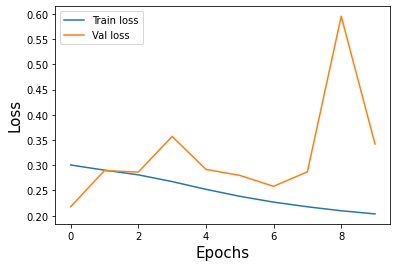

In [30]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

Тем не менее, попроще как будто тоже заучивает модель

In [33]:
val_outputs, val_coords = final_validate(model_resnet, 
                                         criterion,
                                         valid_loader)

loss=0.43
matthews_correlation_coefficient=0.7
ROC_AUC=0.82
Pr-Rec_AUC=0.91


Ниже код для обучения без циклических шагов градиентного спуска

In [26]:
model_cnn = CNN_s1(patch_size=patch_size).to(device)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.BCELoss()
accuracy, loss_hist = train(model_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs = 10)

 10%|███████▉                                                                       | 1/10 [16:47<2:31:11, 1007.91s/it]

Epoch=0  loss=0.3103  val_loss=0.2652  mcc=0.3



 20%|███████████████▊                                                               | 2/10 [34:06<2:16:48, 1026.10s/it]

Epoch=1  loss=0.2969  val_loss=0.2201  mcc=0.23



 30%|███████████████████████▋                                                       | 3/10 [51:09<1:59:32, 1024.71s/it]

Epoch=2  loss=0.2904  val_loss=0.199  mcc=0.36



 40%|██████████████████████████████▊                                              | 4/10 [1:08:23<1:42:48, 1028.14s/it]

Epoch=3  loss=0.2853  val_loss=0.2043  mcc=0.29



 50%|██████████████████████████████████████▌                                      | 5/10 [1:25:11<1:25:04, 1020.99s/it]

Epoch=4  loss=0.2805  val_loss=0.2103  mcc=0.39



 60%|██████████████████████████████████████████████▏                              | 6/10 [1:42:26<1:08:22, 1025.72s/it]

Epoch=5  loss=0.2765  val_loss=0.2033  mcc=0.3


 60%|██████████████████████████████████████████████▏                              | 6/10 [1:54:53<1:16:35, 1148.93s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [ ]:
val_outputs, val_coords = final_validate(model_cnn, 
                                         criterion,
                                         valid_loader)

Посмотрим результаты обучения для разных вариаций

15 x 15, mcc = 0.47

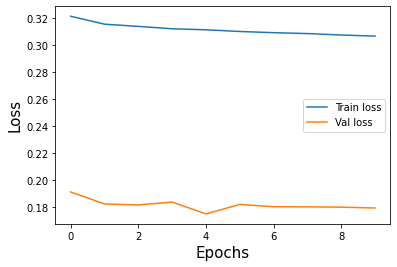

In [22]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

Кажется, что шум на трейне действительно имеет значение, так как лосс для валидации стал заметно ниже

11 x 11, mcc = 0.46

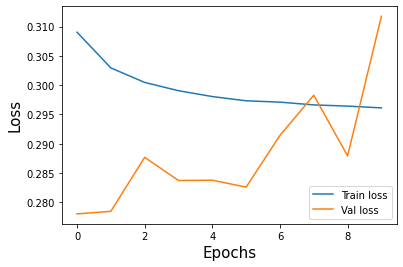

In [24]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

7 x 7, mcc = 0.46

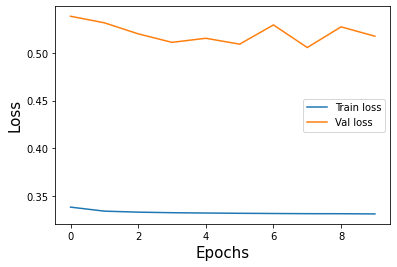

In [26]:
plt.plot(range(10), loss_hist)
plt.plot(range(10), accuracy)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

Сохранение модели

In [24]:
# это должна была быть модель 15х15
torch.save(model_cnn, 'D:/oni/from_lakm/models/model_cnn_s1_2910.pkl') # блин, кажется, ее надо было не так сохранять

![cat](http://memesmix.net/media/created/brtpiy.jpg)

Кажется, ее надо было сохранять вот так:

A common PyTorch convention is to save models using either a .pt or .pth file extension.

In [ ]:
# save
torch.save(model.state_dict(), PATH)

# load
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

# хотя так тоже можно
# если сохранять так, в коде при загрузке надо иметь класс модели (и прогнать его)
# т.е. без кода с архитектурой модели load не запустится
torch.save(model, PATH)
model = torch.load(PATH)
model.eval()

## Оценка качества на тестовых данных

Оценка homemade resnet

In [35]:
# test patches
test_dataset = Patcher(test_image, test_labels, valid_transform, patch_size)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)
# validate on test
test_outputs, test_coords = final_validate(model_resnet, 
                                           criterion,
                                           test_loader)

100%|█████████████████████████████████████████████████████████████████████████████| 4994/4994 [00:25<00:00, 192.61it/s]


loss=0.55
matthews_correlation_coefficient=0.63
ROC_AUC=0.78
Pr-Rec_AUC=0.91


Оценка на простой сверточной

In [38]:
model_cnn = torch.load('D:/oni/from_lakm/models/model_cnn_s1_3110_sgd.pt')

test_outputs, test_coords = final_validate(model_cnn, 
                                           criterion,
                                           test_loader)

loss=0.37
matthews_correlation_coefficient=0.66
ROC_AUC=0.8
Pr-Rec_AUC=0.91


In [ ]:
# test patches
test_dataset = Patcher(test_image, test_labels, valid_transform, patch_size)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)
# validate on test
test_outputs, test_coords = final_validate(model_cnn, 
                                           criterion,
                                           test_loader)

## Формирование выходного изображения

Где-то тут собираем всё в один снимок

Для сборки выходного изображения подготовим патчи и прогоним все через валидацию. Модель возьмем сохраненную

In [20]:
patch_size = 15
train_dataset = Patcher(train_image, train_labels, valid_transform, patch_size) # without noise
valid_dataset = Patcher(val_image, val_labels, valid_transform, patch_size)
test_dataset = Patcher(test_image, test_labels, valid_transform, patch_size)

100%|█████████████████████████████████████████████████████████████████████████████| 4994/4994 [00:48<00:00, 103.06it/s]


In [21]:
batch_size = 512
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=False)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

In [23]:
model_cnn = torch.load('D:/oni/from_lakm/models/model_cnn_s1_3110_sgd.pt')

In [49]:
model_cnn

CNN_s1(
  (conv_stack): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=28800, out_features=1000, bias=True)
    (8): Dropout(p=0.25, inplace=False)
    (9): ReLU()
    (10): Linear(in_features=1000, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [24]:
criterion = nn.BCELoss()

Так как сохраненная модель училась только на половине полного train набора, значения метрик для нее будут выше, чем для валидации и теста, однако не абсолютно великолепны, потому что вторую половину набора модель не видела

In [47]:
print('Train part')
train_outputs, train_coords = final_validate(model_cnn, 
                                             criterion,
                                             train_loader)
print('------------')
print('Val part')
val_outputs, val_coords = final_validate(model_cnn, 
                                         criterion,
                                         valid_loader)

print('------------')
print('Test part')
test_outputs, test_coords = final_validate(model_cnn, 
                                           criterion,
                                           test_loader)

Train part
loss=0.5
matthews_correlation_coefficient=0.71
ROC_AUC=0.86
Pr-Rec_AUC=0.92
------------
Val part
loss=0.34
matthews_correlation_coefficient=0.62
ROC_AUC=0.78
Pr-Rec_AUC=0.93
------------
Test part
loss=0.34
matthews_correlation_coefficient=0.71
ROC_AUC=0.84
Pr-Rec_AUC=0.92


In [54]:
train_part = np.zeros_like(train_labels)
val_part = np.zeros_like(val_labels)
test_part = np.zeros_like(test_labels)

In [55]:
for indx in range(len(train_coords)):
    coord_x, coord_y = train_dataset.coords[train_coords[indx]]
    train_part[coord_x, coord_y] = train_outputs[indx]

In [57]:
for indx in range(len(val_coords)):
    coord_x, coord_y = valid_dataset.coords[val_coords[indx]]
    val_part[coord_x, coord_y] = val_outputs[indx]

In [58]:
for indx in range(len(test_coords)):
    coord_x, coord_y = test_dataset.coords[test_coords[indx]]
    test_part[coord_x, coord_y] = test_outputs[indx]

In [48]:
a, b = valid_dataset.coords[val_coords[7]]
a

14

In [59]:
np.mean(train_part)

0.5940829526178311

In [46]:
result_image[a, b]

0

In [60]:
result_image = np.zeros_like(mask_array) # model output

result_image[:bound_val] = train_part
result_image[bound_val:bound_test] = val_part
result_image[bound_test:] = test_part

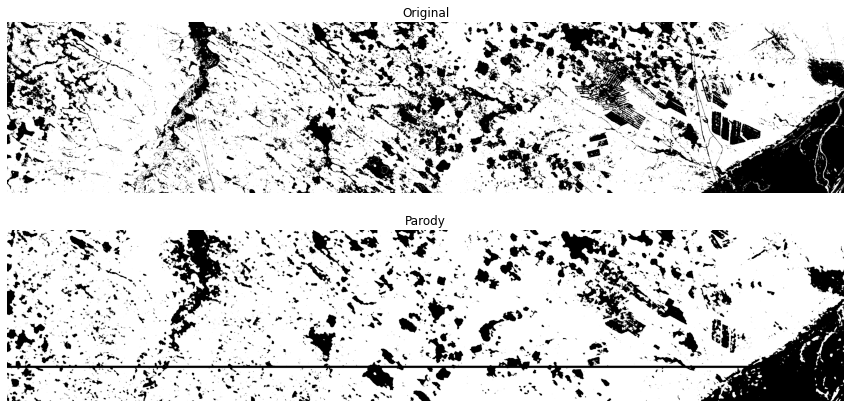

In [61]:
figure1 = mask_array[3500:4500, 100:5000]
figure2 = result_image[3500:4500, 100:5000]

fig, axis = plt.subplots(2, 1, figsize=(15, 7))
axis[0].imshow(figure1, cmap='Greys_r')
axis[1].imshow(figure2, cmap='Greys_r')
axis[0].title.set_text('Original')
axis[1].title.set_text('Parody')
for a in axis:
    a.axis('off') 

Шов..............
Кажется, патч 15 пикселов крупноват, поэтому небольшие безлесые участки оказались съедены, так как их окружение было лесным.

Выгружаем полученное изображение в реальный мир

In [62]:
# дадим ему имя и место
out_raster = "D:/oni/from_lakm/out/result_cnn.tif" 

# экспорт результата
createGeotiff(out_raster, result_image, geo_transform, projection)

## U-Net

In [ ]:
# new patches

# new loader

# u-net

# loss

# train

# val

## Random Forest

Тут, конечно, гораздо МЕНЬШЕ строчек кода

In [12]:
train_image_rf = np.reshape(train_image, [train_image.shape[0] * train_image.shape[1], train_image.shape[2]])

val_image_rf = np.reshape(val_image, [val_image.shape[0] * val_image.shape[1], val_image.shape[2]])

test_image_rf = np.reshape(test_image, [test_image.shape[0] * test_image.shape[1], test_image.shape[2]])


train_labels_rf = train_labels.flatten()

val_labels_rf = val_labels.flatten()

test_labels_rf = test_labels.flatten()

In [13]:
print(train_image_rf.shape)
print(train_labels_rf.shape)

(15374560, 2)
(15374560,)


In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth = 25, n_jobs=4, verbose=2) # oob_score=True - out-of-bag

rf = rf.fit(train_image_rf, train_labels_rf)

# print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

y_pred_train = rf.predict(train_image_rf)
y_pred_val = rf.predict(val_image_rf)
y_pred_test = rf.predict(test_image_rf)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200building tree 27 of 200

building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 10.5min


building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 44.9min


building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 57.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   50.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  2.9min finished


In [21]:
# metrics
labels_rf = np.concatenate((val_labels_rf, test_labels_rf))
outputs_rf = np.concatenate((y_pred_val, y_pred_test))

print(f"matthews_correlation_coefficient={matthews_corrcoef(labels_rf, outputs_rf):.2}")
print(f"ROC_AUC={roc_auc_score(labels_rf, outputs_rf):.2}")
precision, recall, thresholds = precision_recall_curve(labels_rf, outputs_rf)
print(f"Pr-Rec_AUC={auc(recall, precision):.2}")

matthews_correlation_coefficient=0.45
ROC_AUC=0.71
Pr-Rec_AUC=0.87


Я поднялась от 70 деревьев до 200 и от максимальной глубины 10 до 25, но метрики лучше не стали. А больше и более глубоких деревьев уже не помещаются в память

In [22]:
y_pred_train = np.reshape(y_pred_train, (train_image.shape[0], train_image.shape[1]))
y_pred_val = np.reshape(y_pred_val, (val_image.shape[0], val_image.shape[1]))
y_pred_test = np.reshape(y_pred_test, (test_image.shape[0], test_image.shape[1]))

In [23]:
y_pred_test.shape

(1846, 5008)

In [25]:
result_image = np.zeros_like(mask_array) 
result_image.shape

(6146, 5008)

In [26]:
# change to answers
result_image[:bound_val] = y_pred_train
result_image[bound_val:bound_test] = y_pred_val
result_image[bound_test:] = y_pred_test

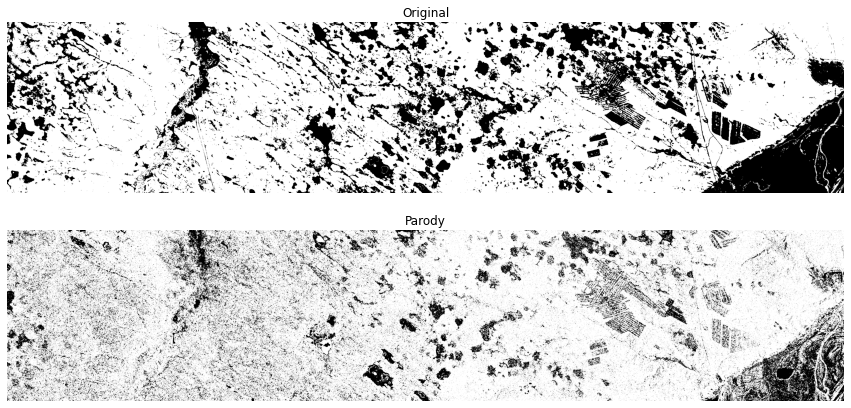

In [35]:
figure1 = mask_array[3500:4500, 100:5000]
figure2 = result_image[3500:4500, 100:5000]

fig, axis = plt.subplots(2, 1, figsize=(15, 7))
axis[0].imshow(figure1, cmap='Greys_r')
axis[1].imshow(figure2, cmap='Greys_r')
axis[0].title.set_text('Original')
axis[1].title.set_text('Parody')
for a in axis:
    a.axis('off') 

Шумненько, особенно в лесах. Видимо, так влияет спекл-шум. Для RF стоило добавить этапов предобработки, ведь он, в отличие от нейросети, сам разбираться с шумом не будет, В лесах из-за шума количеств леса преуменьшено, на нелесных территориях, напроти, преувеличено

In [28]:
out_raster = "D:/oni/from_lakm/out/result_rf.tif" 


# экспорт результата
createGeotiff(out_raster, result_image, geo_transform, projection)

Наверное, сначала надо было сохранить модель, а потом перезапускать ядро..........................

## Песочница

Варианты: 
1) 1 и сигмоида, BCELoss(), _, preds = torch.max(outputs.data,1) между аутом и лоссом, но не везде это есть
https://python-bloggers.com/2022/05/building-a-pytorch-binary-classification-multi-layer-perceptron-from-the-ground-up/

2) 1 и torch.nn.BCEWithLogitsLoss, y_pred_tag = torch.round(torch.sigmoid(y_pred)) для акк
https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

3) 2, кросс

4) 2, softmax, sparse_categorical_crossentropy

In [ ]:
# https://python-bloggers.com/2022/05/building-a-pytorch-binary-classification-multi-layer-perceptron-from-the-ground-up/
# куча метрик

In [ ]:
# batch = next(iter(train_loader))

In [ ]:
# про вычисление координат пиксела
# https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
# xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()

# # supposing x and y are your pixel coordinate this 
# # is how to get the coordinate in space.
# posX = px_w * x + rot1 * y + xoffset
# posY = rot2 * x + px_h * y + yoffset

# # shift to the center of the pixel
# posX += px_w / 2.0
# posY += px_h / 2.0

In [ ]:
# raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20190518_.tif"
# raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20190611_.tif" #
# raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20190729_.tif"
# raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20190822_.tif" #
# raster_path = "D:/oni/from_lakm/tiffs_clip/subalos_S1B_20190927_.tif" #

На посмотреть

https://github.com/d-smit/sentinel2-deep-learning

https://github.com/scikit-learn/scikit-learn/blob/36958fb24/sklearn/feature_extraction/image.py#L323

## Cemetery

In [42]:
# Куда-то в патчер нужно засунуть вычисление координат центрального пиксела и складывание этого знания в датасет
# В начале нам понадобится нарезатель на патчи больших снимков
# Еще он должен узнавать и записывать класс 
# не храним, а на основе свалки координат выбираем патч в гет айтем. а в длине длина свалки координат
# class Patcher(Dataset):
#     def __init__(self, image, mask, transform, patch_size, bound=0, seed=42):
#         super().__init__()
#         self.transform = transform
#         self.rng = np.random.RandomState(seed)
#         self.patches = []
#         self.labels = []
#         self.coords = []
#         im_h, im_w = image.shape[0], image.shape[1]
#         for row in tqdm(range(im_h - (patch_size - 1))):
#             for col in range(im_w - (patch_size - 1)):
#                 if (image[row:row + patch_size, col:col + patch_size] == 0).all(): # empty pixels, go away
#                     break
#                 else:
#                     continue
#                 patch = image[row:row + patch_size, col:col + patch_size]
#                 self.patches.append(patch)
                
#                 label = mask[row + patch_size // 2][col + patch_size // 2] # центральный пиксел
#                 self.labels.append(label)
                
#                 coord = (0, 0)
#                 self.coords.append(coord)
                
#                 # (4300 - 4) * (5008 - 4) = 21 497 184 патчей
#                 # где-то тут память забивается и всё умирает


#     def __getitem__(self, indx):
#         return self.transform(self.patches[indx]), torch.tensor(self.labels[indx]).float(), torch.tensor(self.coords[indx])

#     def __len__(self):
#         return 10000
# #         return len(self.patches)

In [ ]:
# class Patcher(Dataset):
#     def __init__(self, image, mask, transform, patch_size, size=10000, bound=0, seed=42):
#         super().__init__()
        
        
#         self.image = image
#         self.mask = mask
#         self.transform = transform
#         self.patch_size = patch_size
#         self.size = size
#         self.rng = np.random.RandomState(seed)
#         self.im_h, self.im_w = image.shape[0], image.shape[1]             

#     def __getitem__(self, indx):
#         central_x = self.rng.randint(0, self.im_w - (self.patch_size - 1))
#         central_y = self.rng.randint(0, self.im_h - (self.patch_size - 1))
#         half_patch = self.patch_size // 2
#         if (self.image[(central_y - half_patch):(central_y + half_patch + 1), 
#                  (central_x - half_patch):(central_x + half_patch + 1)] != 0).all():
#             patch = self.image[(central_y - half_patch):(central_y + half_patch + 1), 
#                           (central_x - half_patch):(central_x + half_patch + 1)]
#             label = self.mask[central_y][central_x]
#             coords = (0, 0) # geographical, now dummy
#             return self.transform(patch), torch.tensor(label).float(), torch.tensor(coords) # зачем флоат лейблам?

#     def __len__(self):
#         return self.size # 5х5 патчей получается 21,5 млн штук, хотелось бы ограничивать